In [2]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import numpy.linalg as la
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy import stats as st
from scipy.fft import fft, fftfreq
import sys
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
np.set_printoptions(precision=2)
%matplotlib inline
plt.style.use(style='seaborn-v0_8')

In [3]:
'''df1 = pd.read_csv(r'ITC.NS.csv')print(df1.shape)df = df1[['Close']].copy()#df.loc[len(df.index)]=408.3df.to_csv(r'ITC.NS.csv')df.shape'''

"df1 = pd.read_csv(r'ITC.NS.csv')print(df1.shape)df = df1[['Close']].copy()#df.loc[len(df.index)]=408.3df.to_csv(r'ITC.NS.csv')df.shape"

In [4]:
def getData(name, per, intrvl, cols = ['Close']):
    df = yf.Ticker(name)
    df = pd.DataFrame(df.history(period=per, interval=intrvl))
    
    return df[cols].copy()

In [5]:
def minMax(df, lower, upper):
    vec = np.array(df)
    #print(df)
    for j in np.arange(vec.shape[1]):
        min = np.min(vec[:,j])
        max = np.max(vec[:,j])
        for i in np.arange(vec.shape[0]):
            vec[i,j] = ((vec[i,j] - min)/(max-min))*(upper-lower)+lower

    return vec

inner = lambda a,b: np.prod(a[:]+b[:])


In [6]:
class LinearRegression:
    #multivar linear regression
    def __init__(self, df, *cols):
        #if len(col)==2:
            self.new_mat = pd.DataFrame()
            self.columns = np.array(cols)
            for col in cols:
                self.new_mat[df.iloc[:,col-1:col].columns] = np.array(df.iloc[:,col-1:col])
                
            self.m = self.new_mat.shape
            self.X_train = pd.DataFrame()
            self.y_train = pd.DataFrame()
            self.U = np.empty([self.m[1],self.m[1]], dtype=float)
            self.V = np.empty([self.m[1],1], dtype=float)
            self.W = np.empty([self.m[1],1], dtype=float)
            
        #else:
            #print("Enter two Columns")
            
    def show(self):
        display(self.new_mat)
        
    def target(self, target):
        
        self.y_train[self.new_mat.iloc[:,target-1:target].columns] = np.array(self.new_mat.iloc[:,target-1:target])
        #display(self.y_train)
        self.X_train = self.new_mat.drop(self.y_train.columns, axis=1)
        #self.X_train['1'] = 1 
        sums = np.array([])
        for col in np.delete(np.arange(self.m[1]), target-1):
            sums = np.append(sums, np.sum(self.new_mat.iloc[:,col]))
            
        trgt_sum = np.sum(self.new_mat.iloc[:,target-1])  #here
        
        for i in np.arange(len(sums)):
            self.U[0][i] = sums[i]
            
        self.U[0][-1] = self.new_mat.iloc[:,target-1].count()
        
        self.V[0][0] = trgt_sum
        
        for i in np.arange(len(sums)):
            for j in np.arange(len(sums)):
                self.U[i+1][j] = np.sum(self.X_train.iloc[:,j]/self.X_train.iloc[:,i])
                
            self.U[i+1][-1] = np.sum(1/self.X_train.iloc[:,i])
            self.V[i+1][0] = np.sum(self.y_train.iloc[:,0]/self.X_train.iloc[:,i])   #here
                
        self.W = la.inv(self.U) @ self.V
        #print(self.W)
        
    def predict(self, *test_data):
        pred_val = 0
        i = 0
        for value in test_data:
            pred_val += self.W[i][0]*value
            #print(self.W[i][0],value,pred_val)
            i+=1
        
        return pred_val + self.W[-1][0]
    
    def plot(self, sz=10, wd=1):
        if self.X_train.shape[1]==1:
            ledgy = list()
            y_pred = np.array([])
            for i in np.arange(self.m[0]):
                 y_pred = np.append(y_pred, self.predict(*tuple(self.X_train.iloc[i,:])))
                
            for col in np.arange(1,self.m[1]):
                plt.scatter((self.X_train.iloc[:,col-1:col]), (self.y_train), color=(np.random.random(),np.random.random(),np.random.random()), s=sz)
                ledgy.append(self.X_train.iloc[:1,col-1:col].columns[0])
            
            plt.plot((self.X_train.iloc[:,:1]), (y_pred), color=(np.random.random(),np.random.random(),np.random.random()), linewidth=wd+0.5)
            plt.legend(ledgy, loc=(1,0.7))
            plt.ylabel(self.y_train.iloc[:1,:1].columns[0])
            plt.show()
        else:
            return "Please Enter one on one relation"
    
    def error(self,perc=80):
        if self.X_train.shape[1]>=-1:
            y_pred = np.array([])
            for i in np.arange(self.m[0]):
                y_pred = np.append(y_pred, self.predict(*tuple(self.X_train.iloc[i,:])))
                
            #acc = 100 - ((abs(np.reshape(np.array(self.y_train), (self.m[0],))-y_pred)/np.reshape(np.array(self.y_train), (self.m[0],)))*100)
            #print(len(abs(np.reshape(np.array(self.y_train), (22,))-y_pred)/np.reshape(np.array(self.y_train), (22,))))
            acc = abs(np.reshape(np.array(self.y_train), (self.m[0],))-y_pred)
            sns.boxplot(acc)
            plt.show()
            sns.histplot(acc, kde=True)
            plt.show()
            print(f'mean:{np.mean(acc)},std:{np.std(acc)}')
            return np.percentile(acc,perc)
        else:
            return "Please Enter one on one relation"

In [7]:
df1 = getData(name = 'adanient.ns', per= '10d', intrvl= '15m')
#df1=df1*(834/28.34)
#df1.to_csv('stock_data.csv')
#df1 = pd.DataFrame(fft(df1))

In [8]:
df1.shape

(250, 1)

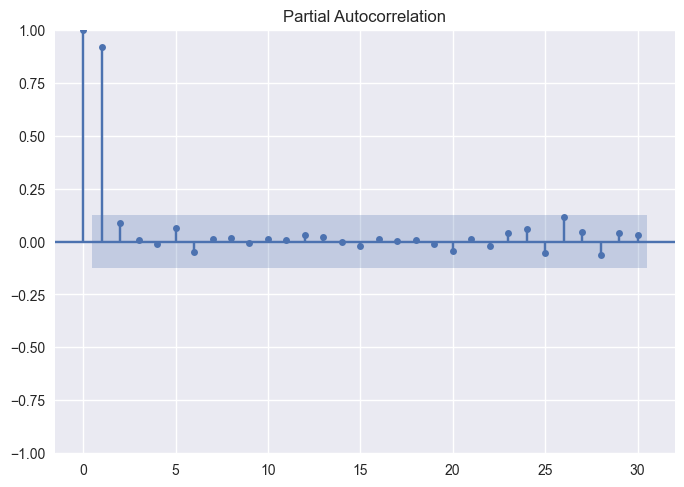

In [9]:
plot_pacf(df1, lags=30);

In [10]:
n_lags = 26
temp = [df1]+[df1.shift(-i) for i in np.arange(1,n_lags+1)]


In [11]:
#dff = pd.concat([df1,df1['Close'].shift(-1),df1['Close'].shift(-2),df1['Close'].shift(-3),df1['Close'].shift(-4),df1['Close'].shift(-5),df1['Close'].shift(-6),df1['Close'].shift(-7)], axis=1)

cols = [
        df1,df1.shift(-1),
        df1.shift(-29),
        df1.shift(-36),
        # df1.shift(-34),
        # # df1.shift(-2),
        # # df1.shift(-3),
        # # df1.shift(-4),
        ]

cols = temp

dff = pd.concat(cols, axis=1)
#dff = pd.concat([df1,df1['Close'].shift(-1),df1['Close'].shift(-2),df1['Close'].shift(-3),df1['Close'].shift(-4),df1['Close'].shift(-5)], axis=1)
dff.columns = np.arange(len(cols))
dff = dff.dropna()
dff.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-03-27 14:00:00+05:30,3124.399902,3126.050049,3135.000000,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,...,3156.399902,3175.000000,3193.000000,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902
2024-03-27 14:15:00+05:30,3126.050049,3135.000000,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,...,3175.000000,3193.000000,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951
2024-03-27 14:30:00+05:30,3135.000000,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,3158.399902,...,3193.000000,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951,3217.850098
2024-03-27 14:45:00+05:30,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,3158.399902,3152.000000,...,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951,3217.850098,3180.250000
2024-03-27 15:00:00+05:30,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,3158.399902,3152.000000,3155.600098,...,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951,3217.850098,3180.250000,3197.100098


In [12]:
#sns.heatmap(dff.corr(), annot=True, cmap='RdBu')
def AGO(df):
    cdf = df.copy()
    out = pd.DataFrame()
    for i in np.arange(cdf.shape[0]):
        row = np.array(cdf.iloc[i,:])
        #print(len(row))
        x= [row[j] - row[j-1] for j in np.arange(1,len(row))]
        out[i] = x
        #print(pd.Series(x))
    return out.T

In [13]:
n = 0.95
size  = int(df1.shape[0]*n)
size = dff.shape[0]-10
df_train = dff.iloc[:size,:]
df_test = dff.iloc[size:,:]

In [14]:
lr = LinearRegression(df_train, *np.arange(1,len(cols)+1))

In [15]:
np.arange(1,len(cols)+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [16]:
lr.target(np.arange(1,len(cols)+1)[-1])
#lr.show()

In [17]:
l = list()
rangep = np.array([(400,408.25),(409,411.5),(411.5,412),(412,413)])
for i in np.arange(df_test.shape[0]):
    l.append(lr.predict(*(df_test.iloc[i,:-1])))
l=np.array(l)

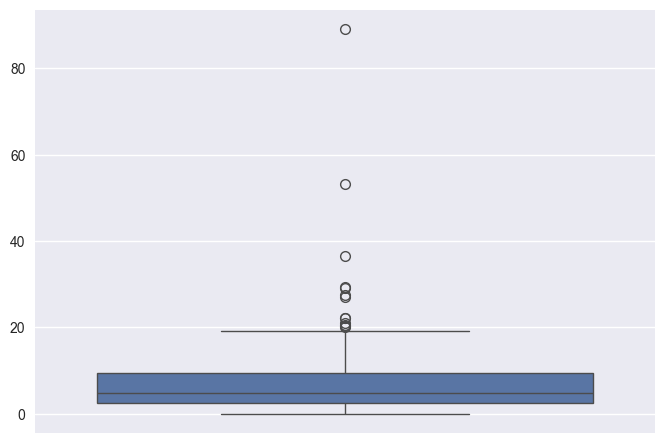

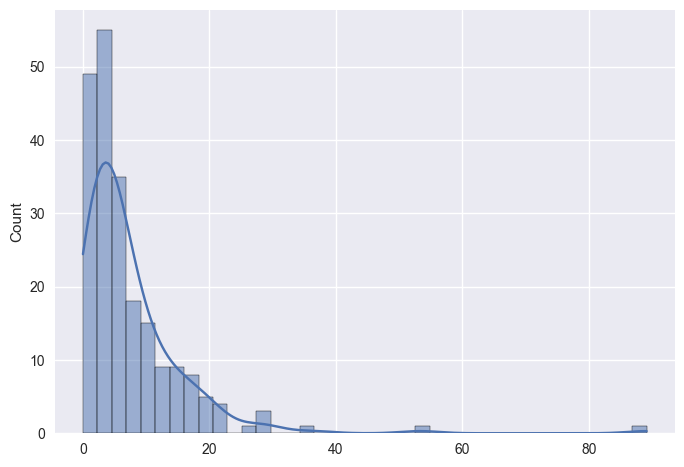

mean:7.446131994758206,std:9.037697951808166


13.977706364200365

In [18]:
#intv=abs((np.array(df_test.iloc[:,2])-l)).mean()
intv=lr.error(85)
intv

In [19]:
#print(f'predicted:{np.array(l+intv),np.array(l-intv)}')

In [20]:
def plot_predict(actual,l, intv,t=-1, title = False):
    plt.figure(figsize=(5,3.8))
    lower,upper = l-intv,l+intv
    actual = np.arange(-len(l),len(np.array(df_test.iloc[:,-1])))
    #print(actual)
    plt.plot(np.array(df_test.iloc[:,t]), c='k', alpha=0.4) #np.array(df_test.iloc[:,-1])
    #print(np.array(df_test.iloc[:,-1]))
    plt.plot(lower[1:],'r--', label='lower')
    plt.plot(l[1:], c='b',label = 'predicted')
    plt.plot(upper[1:],'g--', label='upper')
    plt.legend(loc='upper left')
    if title:
        plt.title('My Model')
    plt.show()
    

In [21]:
def forec_tree(prev_days,price, intv, depth, fluctFact=0.25, dr=1):
    prev_days = np.append(prev_days, price)
    prev_days = prev_days[1:]
    udr = 0.8
    ldr = 1.25
    m = m1 = lr.predict(*prev_days)
    #prev_days = np.append(prev_days, m)
    up,low = m+intv,m-intv
    disth = dr*abs(price-up)
    distl = abs(price-low)
    factor = distl/(distl+disth)
    if depth==-5:
        #print("in -5")
        return factor
        
    if depth<=0 and depth>-5:
        u = forec_tree(prev_days, price+(fluctFact)*1*intv, intv, depth-1, fluctFact= fluctFact, dr=1 if fluctFact<=0.5 or fluctFact >= 1.2 else udr*dr)
        d = forec_tree(prev_days, price+(fluctFact)*1*intv, intv, depth-1, fluctFact= fluctFact, dr=1 if fluctFact<=0.5 or fluctFact >= 1.2 else ldr*dr)
        #print(f"IF {price:7.6} THEN:{factor:5.2},up:{up:7.6},mean:{m1:7.6},low:{low:7.6} d({depth-1})\n")
        return (factor*u*d)**(1/3)
    
    elif depth>0:
        d = forec_tree(prev_days,price-(fluctFact)*1*intv, intv, depth-1, fluctFact=fluctFact,dr=1 if fluctFact<=0.5 or fluctFact >=1.2 else ldr*dr)
        #print(f"IF {price:7.6} THEN:{factor:5.2},up:{up:7.6},mean:{m1:7.6},low:{low:7.6} d({depth-1})\n")
        u = forec_tree(prev_days,price+(fluctFact)*1*intv, intv, depth-1, fluctFact=fluctFact,dr=1 if fluctFact<=0.5 or fluctFact >= 1.2 else udr*dr)
        factor = (factor*d*u)**(1/3)
        print(f"IF {price:7.6} THEN: {factor:5.2},up:{up:7.6},mean:{m1:7.6},low:{low:7.6} d({depth-1})\n")
        return factor

In [22]:
def forec(price_today, n_points, t=-1, read=True):
    price_today = float(df_test.iloc[t,-1])
    prev_days = np.append(np.array(df_test.iloc[t-1,:-1]), price_today)
    prev_days = prev_days[1:]
    output = np.empty((n_points,4))
    #print(prev_days)
    for i in np.arange(n_points):
        m = m1 = lr.predict(*prev_days)
        up,low = m+intv,m-intv
        disth = abs(price_today-up)
        distl = abs(price_today-low)
        factor = distl/(distl+disth)
        output[i][0] = factor
        output[i][1] = up
        output[i][2] = m1
        output[i][3] = low
        '''if factor<0.47:
            m = price_today = (m+(factor*.001*m))
        else:
            m = price_today = (m-factor*.001*m)'''
        price_today = m
        prev_days = np.append(np.array(prev_days),price_today)
        prev_days = prev_days[1:]
        if read:
            print(f'[{factor:5.2}, up: {up:7.6}, mean: {m1:7.6}, low: {low:7.6}], {float(df_test.iloc[t,-1]):7.6}')
    if read==False:
        return output


In [23]:
df_test.tail()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-03-27 14:00:00+05:30,3124.399902,3126.050049,3135.000000,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,...,3156.399902,3175.000000,3193.000000,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902
2024-03-27 14:15:00+05:30,3126.050049,3135.000000,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,...,3175.000000,3193.000000,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951
2024-03-27 14:30:00+05:30,3135.000000,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,3158.399902,...,3193.000000,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951,3217.850098
2024-03-27 14:45:00+05:30,3125.000000,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,3158.399902,3152.000000,...,3185.350098,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951,3217.850098,3180.250000
2024-03-27 15:00:00+05:30,3121.199951,3122.100098,3127.000000,3110.550049,3127.500000,3135.000000,3133.850098,3158.399902,3152.000000,3155.600098,...,3183.000000,3196.850098,3199.000000,3206.000000,3212.449951,3211.399902,3236.199951,3217.850098,3180.250000,3197.100098


In [24]:
t = -1
#-k mean previous k days
print(np.array(df_test.iloc[t,:-1]),df_test.iloc[t,-1])
#print(np.array([400.14,398.5,398.75,400.23]))
#aaj ka close and previous k days ka close, AR(k) here k=5

[3121.2  3122.1  3127.   3110.55 3127.5  3135.   3133.85 3158.4  3152.
 3155.6  3150.45 3152.65 3153.3  3156.4  3175.   3193.   3185.35 3183.
 3196.85 3199.   3206.   3212.45 3211.4  3236.2  3217.85 3180.25] 3197.10009765625


In [25]:
price_today = float(df_test.iloc[t,-1])

yesterday = np.array(df_test.iloc[t,:-1])*1 
pred_high_today,m,pred_low_today = (lr.predict(*yesterday)+intv,lr.predict(*yesterday),lr.predict(*yesterday)-intv)
#decision = [1 if price[-1]<high else 0, 1 if price[-1]<m else 0,  1 if price[-1]<low else 0]
#print(price_today<pred_high_today, price_today>pred_low_today)
today = list(yesterday[1:])
today.append(price_today)
today = np.array(today)
#print(today)
pred_high_tom,m,pred_low_tom = lr.predict(*today)+intv,lr.predict(*today),lr.predict(*today)-intv
if price_today<pred_high_today and price_today>pred_low_today:
    '''today = list(yesterday[1:])
    today.append(price_today)
    today = np.array(today)
    #print(today)
    pred_high_tom,m,pred_low_tom = (lr.predict(*today)+intv,lr.predict(*today),lr.predict(*today)-intv)'''
    distfh = abs(price_today-pred_high_tom)#np.sqrt((price_today-pred_high_tom)**2)
    distfl = abs(price_today-pred_low_tom)#np.sqrt((price_today-pred_low_tom)**2)
    #print(price_today-pred_high_tom,price_today-pred_low_tom)
    factor = distfl/(distfh+distfl)
    print(factor,f'Tom_Upper: {pred_high_tom}, Tom_Lower: {pred_low_tom}, mean:{m}')

else:
    sigdhl = abs(price_today-pred_high_today) 
    sigdfl = abs(price_today-pred_low_today)
    
    distfh = abs(price_today-pred_high_tom)
    distfl= abs(price_today-pred_low_tom)
    factor = distfl/(distfl+distfh)
    print(f'significance = {sigdhl/intv:4.3}')
    print(f'{factor:5.2}',f'Tom_Upper:{pred_high_tom:7.5}, Tom_Lower:{pred_low_tom:7.5}, mean:{m:7.5}, Tod_Upper: {pred_high_today:7.5}, Tod_Lower: {pred_low_today:7.5}')     
    #decision boundary is around factor=0.35   
    #factor below 0.35 then down 
    #if significance below 0.4 and above 1 then use pred_tom for dists
    #if significance bw 0.4 and 1 then use pred_today for dists

significance = 0.292
 0.56 Tom_Upper: 3209.5, Tom_Lower: 3181.5, mean: 3195.5, Tod_Upper:  3193.0, Tod_Lower:  3165.1


In [26]:

#np.append(l,np.array((forec(411.75,7,t=-1,read=False)[:,2])))
dev = np.std(minMax(df1.tail(10), 0 , 1))
dev

0.28189783761682735

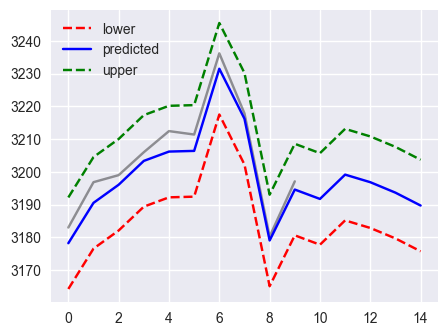

In [27]:
#The number after THEN is RF 
plot_predict(today,np.append(l,np.array((forec(3187.95,6,t=-1,read=False)[:,2]))),intv,t=-1)

In [28]:
t=-1
prev_days = np.array(df_test.iloc[t,:-1])
forec_tree(prev_days,float(df_test.iloc[t,-1]),
           intv,
           depth=3,
           fluctFact= dev*1)


IF 3189.22 THEN:  0.58,up:3202.87,mean: 3188.9,low:3174.92 d(0)

IF  3197.1 THEN:  0.61,up:3210.14,mean:3196.17,low:3182.19 d(0)

IF 3193.16 THEN:  0.46,up:3213.15,mean:3199.17,low: 3185.2 d(1)

IF  3197.1 THEN:  0.61,up:3209.47,mean:3195.49,low:3181.52 d(0)

IF 3204.98 THEN:  0.64,up:3216.74,mean:3202.77,low:3188.79 d(0)

IF 3201.04 THEN:  0.49,up:3220.42,mean:3206.45,low:3192.47 d(1)

IF  3197.1 THEN:   0.5,up:3209.46,mean:3195.48,low: 3181.5 d(2)



0.5037484746838643

In [29]:
forec(3187.95,3,t=t )

[ 0.59, up: 3208.57, mean: 3194.59, low: 3180.61],  3197.1
[  0.6, up: 3205.71, mean: 3191.73, low: 3177.75],  3197.1
[ 0.23, up: 3213.13, mean: 3199.16, low: 3185.18],  3197.1


In [30]:
df1.tail(10)

,Close
Datetime,
2024-03-28 13:00:00+05:30,3183.000000
2024-03-28 13:15:00+05:30,3196.850098
2024-03-28 13:30:00+05:30,3199.000000
2024-03-28 13:45:00+05:30,3206.000000
2024-03-28 14:00:00+05:30,3212.449951
2024-03-28 14:15:00+05:30,3211.399902
2024-03-28 14:30:00+05:30,3236.199951
2024-03-28 14:45:00+05:30,3217.850098
2024-03-28 15:00:00+05:30,3180.250000


In [642]:
from PIL import Image

In [643]:
def convolve2D(sqmat,conmat):
    conshape = conmat.shape[0]
    sqmat = sqmat[:(conshape*(sqmat.shape[0]//conshape)), :(conshape*(sqmat.shape[1]//conshape))]
    newmat = np.empty(shape=(sqmat.shape[0]-conshape//2,sqmat.shape[0]-conshape//2))
    for row in np.arange(conshape//2,sqmat.shape[0]-(conshape//2)-1):
        for col in np.arange(conshape//2,sqmat.shape[0]-(conshape//2)-1):
            mini = np.array([[sqmat[i,j] for i in np.arange(row-(conshape//2), row+(conshape//2)+1)] for j in np.arange(col-(conshape//2), col+(conshape//2)+1)])
            newmat[row,col] = np.sum([[mini[i,j]*conmat[i,j] for i in np.arange(conshape)] for j in np.arange(conshape)])
    
    return newmat


In [644]:
def minmaxImager(df, lower=0,upper=16, convolve = False):
    vec = minMax(df, lower, upper)
    sqmat = vec @ vec.T
    #print(sqmat.shape)
    if isinstance(convolve,np.ndarray):
        conmat = np.array(convolve)
        cmat = convolve2D(sqmat=sqmat, conmat=conmat)
        img = Image.fromarray(cmat)
        return img.show()
    else:
        img = Image.fromarray(sqmat)
        return img.show()

In [645]:
col = [
    'High',
    #'Close',
    'Low'
       ]
df = getData('usdinr=x', per = '3wk', intrvl='15m',cols=col)
df = df if len(col)==1 else np.array(abs(df.iloc[:,0:1]))-np.array(abs(df.iloc[:,1:2]))
#df

In [646]:
minmaxImager(df, upper=np.sqrt(256/len(col)), convolve=np.array([
                        #[0, 0, 0, 0, 0],
                        [-2, -2, -2],
                        [-2, 16 if len(col)==1 else 17, -2],
                        [-2, -2, -2],
                        #[0, 0, 0, 0, 0]
                        ]))

In [647]:
weights=np.reshape(lr.W, (lr.W.shape[0],))

In [648]:
def MSE(w,X,y_true, diff=False):
    y_pred = np.empty((y_true.shape[0],))
    for row in np.arange(X.shape[0]):
        #z = np.array(X.iloc[row,:]).T @ w[:-1]- 1*w[-1]
        y_pred[row] = (np.array(X.iloc[row,:]) @ w[:-1].T)+ 1*w[-1]
        #print(np.array(X.iloc[row,:]) , w[:-1].T, 1*w[-1])
        #break
        
    #MSE = ((np.array(lr.y_train).reshape(lr.y_train.shape[0],)-y_pred)**2)
    if diff:
        MSE = (np.array(lr.y_train).reshape(lr.y_train.shape[0],)-y_pred)
        return MSE.mean()
    else:
        MSE = ((np.array(lr.y_train).reshape(lr.y_train.shape[0],)-y_pred)**2)
        return MSE.mean()

In [649]:
MSE(weights,lr.X_train,lr.y_train,diff=False)

137.12486595147942

In [650]:
a = MSE(weights,lr.X_train,lr.y_train,diff=True)

In [651]:
weights

array([ 1.50e-01, -1.71e-01,  5.20e-02,  5.73e-02, -1.02e-01,  2.59e-02,
       -5.41e-02,  3.27e-03,  1.22e-01, -3.75e-02, -1.29e-02, -7.20e-02,
        6.87e-02,  2.86e-02,  1.74e-02, -1.14e-01,  3.45e-02,  5.93e-02,
       -6.83e-02,  1.77e-02,  3.92e-02,  1.11e-01, -7.01e-02,  6.47e-02,
       -8.53e-02,  9.23e-01,  3.75e+01])

In [652]:
randw = np.random.randn(5,)

In [653]:
def regess_GD(w,X,stepsz=0.00000001001):
    gd_W = np.copy(w)
    i=1
    error = MSE(w,lr.X_train,lr.y_train,diff=False)
    print(error,gd_W)
    while(error>19):
        for wt in np.arange(w.shape[0]-1):
            gd_W[wt] = -1*stepsz*MSE(w,lr.X_train,lr.y_train,diff=True)*(X.iloc[:,wt].mean())
            
        gd_W[-1] = -1*stepsz*MSE(w,lr.X_train,lr.y_train,diff=True)
         
        error_n = MSE(gd_W,lr.X_train,lr.y_train,diff=False)
        
        if error_n<error:
            print("Im here")
            error = error_n
            stepsz -= a*345.27        #.000000512
            
        elif error_n==error:
            print("equal")
            stepsz += a*3.45
        
        else:
            error=error_n
            stepsz *=  0.00001
            print("Im in else")
            for wt in np.arange(w.shape[0]-1):
                gd_W[wt] = 1*stepsz*MSE(w,lr.X_train,lr.y_train,diff=True)*(X.iloc[:,wt].mean())
        
            gd_W[-1] = 1*stepsz*MSE(w,lr.X_train,lr.y_train,diff=True)
        
        w=gd_W
        
        if error<2000:
            
            
            
            print(i,error_n)
        i+=1
        
    return gd_W,error
        

In [796]:
import autobnn as ab
import jax
model = ab.operators.Add(
    bnns=(ab.kernels.PeriodicBNN(width=n_lags,period=n_lags),
          ab.kernels.OneLayerBNN(width=n_lags, period=n_lags),
          ab.kernels.LinearBNN(width=n_lags),
          ab.kernels.MaternBNN(width=n_lags)))

estimator = ab.estimators.AutoBnnMapEstimator(
    model, 'normal_likelihood_logistic_noise', jax.random.PRNGKey(42),
    periods=[n_lags])

In [54]:
from sklearn.model_selection import train_test_split

In [92]:
X = np.array(dff.drop(n_lags,axis=1))
y = np.array(dff[n_lags])
#estimator.fit(X[:-10], y)

In [93]:
low, mid, high = estimator.predict_quantiles(X[-10:],(25,60,75))
p = estimator.predict(X[-10:])

NameError: name 'estimator' is not defined

In [94]:
print(np.mean((abs(np.array(df1.tail(10))-mid))))

NameError: name 'mid' is not defined

NameError: name 'mid' is not defined

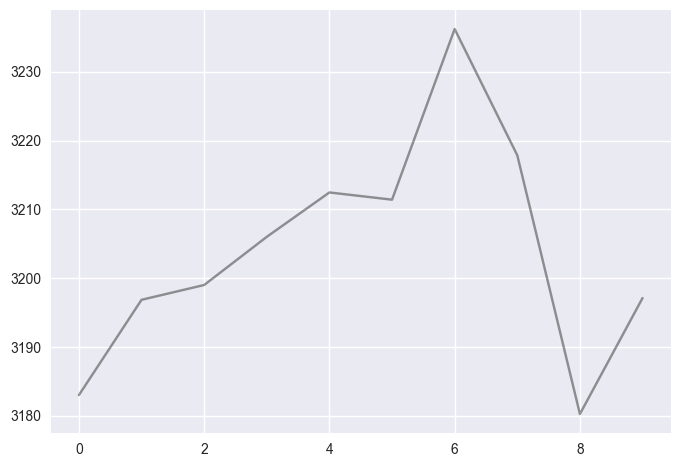

In [95]:
show = 10
x = np.arange(1,show+1)
plt.plot(np.array(df1.tail(show)),c='k', alpha=0.4)
plt.plot(mid,)
plt.plot(low, '--r')
plt.plot(high, '--g')
plt.title('AutoBNN')
plt.legend(['Actual','Predicted','Lower','Upper'])

In [108]:
X_train,X_test,y_train,y_test = train_test_split(X[0],y, test_size=10, shuffle=False, random_state=1001)
y_test.shape

ValueError: Found input variables with inconsistent numbers of samples: [26, 224]

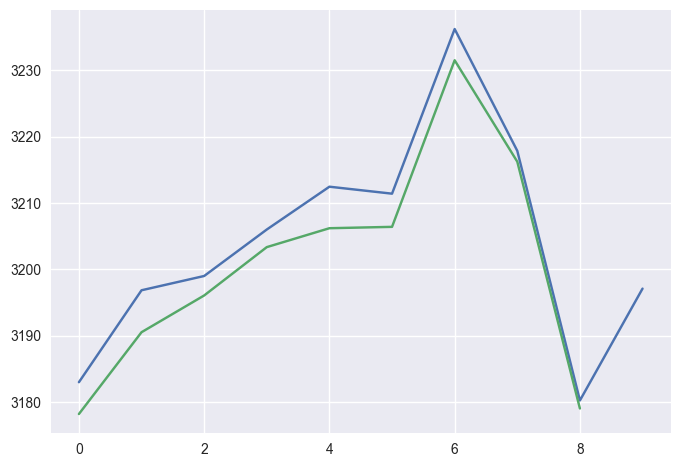

In [152]:
plt.plot(y_test)
plt.plot(l[1:])

In [154]:
np.mean(abs(l[1:]-y_test[:-1]))

3.943139810918486